#AUTOENCODER FOR ANOMALY DETECTION IN EDGE DEVICE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import numpy as np
import os
import pandas as pd
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf

**Variable Selection**

After observing the behavior of each variable, the following decisions are made:


*   edge_soc_temp
*   edge_load1
*   edge_load15
*   delta_recv
*   delta_sent
*   edge_current
*   motor_freq
*   motor_sound




In [ ]:
# Read data
pd.options.mode.copy_on_write = True #to save on memory and avoid making copies of data until written to
my_file = '/content/drive/MyDrive/Colab Notebooks/project/MODELS/normalized/edge4/edge4_1.csv'
df = pd.read_csv(my_file)
df = df.reindex(['localtime', 'indoor_temp', 'indoor_humidity', 'edge_soc_temp', 'edge_load1', 'edge_load15',
       'delta_sent', 'delta_recv', 'edge_current', 'motor_sound', 'motor_freq', 'motor_volt',
       'motor_current', 'motor_recipe','edge_cpu_freq', 'edge_load5','edge_cpu_voltage', 'edge_memory_free',
       'edge_memory_avail', 'fault_type', 'attack_type', 'anomaly', 'edge_wifi_send', 'edge_wifi_receiv',
       'normal', 'A', 'E', 'F', 'N'], axis=1)
x_train=df.iloc[:,3:11]
print(x_train.shape)

**Generate training sequences**

The data is found in the form (n_samples, n_features) and must be transformed into the form (n_samples, n_times, n_features) with a window n_times equal to 300 data, that is, approximately 1 minute.

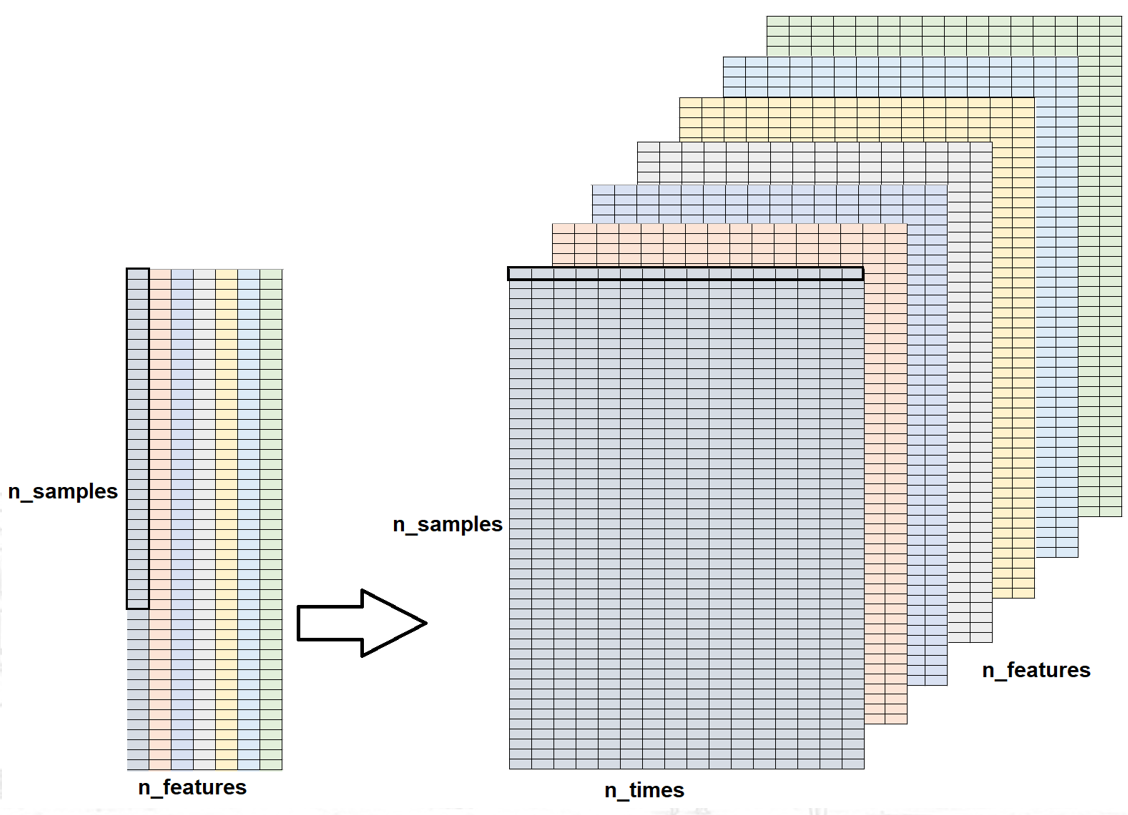

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/IMAGES/sequence.png', width=700, height=400)

In [4]:
# Generate training sequence
def create_sequences(values, n_samples, n_times, n_features):
    output = np.zeros( (n_samples-n_times, n_times, n_features) )
    for j in range(n_features):
        features = []
        for i in range(n_samples - n_times):
            output[i,:,j]=values[i : (i + n_times),j]
    return output

In [ ]:
# Generate a first x_train sequence so that the model can determine the shape of the input and output
df_training = np.array(x_train.iloc[:,:])
N_SAMPLES= df_training.shape[0]
N_TIMES = 300
N_FEATURES = df_training.shape[1]
x_train= create_sequences(df_training, N_SAMPLES, N_TIMES, N_FEATURES)
x_train = x_train.astype(np.float32)
print(x_train.shape)


In [6]:
# Autoencoder CONV1D Model
def autoencoder_model(x_train):
  import tensorflow as tf
  from numpy import array
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import Conv1D
  model = keras.Sequential(
    [
      layers.Conv1D( filters=64, kernel_size=5, padding="same", strides=1, activation="relu", input_shape=(x_train.shape[1], x_train.shape[2])),
      layers.Dropout(rate=0.2),
      layers.Conv1D( filters=32, kernel_size=5, padding="same", strides=1, activation="relu" ),
      layers.Dropout(rate=0.2),
      layers.Conv1D( filters=7, kernel_size=5, padding="same", strides=1, activation="relu" ),

      layers.Conv1DTranspose( filters=7, kernel_size=5, padding="same", strides=1, activation="relu" ),
      layers.Dropout(rate=0.2),
      layers.Conv1DTranspose( filters=32, kernel_size=5, padding="same", strides=1, activation="relu" ),
      layers.Dropout(rate=0.2),
      layers.Conv1DTranspose( filters=64, kernel_size=5, padding="same", strides=1, activation="relu" ),
      layers.Dense(units=x_train.shape[2], activation='sigmoid')
    ]
  )
  return model

**Compilar el modelo en la TPU de Colab**

In [ ]:
# Detect hardware
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model= autoencoder_model(x_train)
    model.compile( optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'],  loss='mse')
model.save("/content/drive/MyDrive/Colab Notebooks/project/MODELS/models/model_conv1d.keras")
model.summary()

In [9]:
#Create list of all files with normal data
files_dic1 = {'/content/drive/MyDrive/Colab Notebooks/project/MODELS/normalized/edge1/': ['edge1_10.csv', 'edge1_2.csv', 'edge1_3.csv', 'edge1_4.csv', 'edge1_5.csv', 'edge1_6.csv', 'edge1_7.csv', 'edge1_9.csv']}
files_dic2 = {'/content/drive/MyDrive/Colab Notebooks/project/MODELS/normalized/edge2/': ['edge2_2.csv', 'edge2_3.csv', 'edge2_4.csv', 'edge2_5.csv', 'edge2_6.csv', 'edge2_7.csv', 'edge2_8.csv']}
files_dic3 = {'/content/drive/MyDrive/Colab Notebooks/project/MODELS/normalized/edge3/': ['edge3_1.csv',  'edge3_2.csv', 'edge3_3.csv', 'edge3_4.csv', 'edge3_5.csv', 'edge3_6.csv', 'edge3_7.csv']}
files_dic4 = {'/content/drive/MyDrive/Colab Notebooks/project/MODELS/normalized/edge4/': ['edge4_1.csv',  'edge4_2.csv', 'edge4_3.csv', 'edge4_4.csv', 'edge4_5.csv', 'edge4_6.csv', 'edge4_7.csv', 'edge4_8.csv', 'edge4_9.csv']}
files_dic = [files_dic1,files_dic2,files_dic3, files_dic4]

In [ ]:
#Group the path of all files into a single list
from pathlib import Path
datos =[]
for m in range(len(files_dic)):
  for key,value in files_dic[m].items():
    for file in value:
      my_file =key + file
      datos.append(my_file)
print(datos)


**Training the model**

The model is trained with each csv file until the loss function is minimized
and accuracy is maximized.

As the model is stored in Google Drive, when the history is graphed, you can choose the version (epoch) with the best metrics and return to that version in Google.

In [ ]:
# Training the model:
from pathlib import Path
import random
import json
N_TIMES = 300
with tpu_strategy.scope():
  model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/project/MODELS/models/model_conv1d.keras", compile=False)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
for k in range(50):
  for jx in range(len(datos)):
    print(datos[jx])
    df = pd.read_csv(datos[jx])
    df = df.reindex(['localtime', 'indoor_temp', 'indoor_humidity', 'edge_soc_temp', 'edge_load1', 'edge_load15',
      'delta_sent', 'delta_recv', 'edge_current', 'motor_sound', 'motor_freq', 'motor_volt',
      'motor_current', 'motor_recipe','edge_cpu_freq', 'edge_load5','edge_cpu_voltage', 'edge_memory_free',
      'edge_memory_avail', 'fault_type', 'attack_type', 'anomaly', 'edge_wifi_send', 'edge_wifi_receiv',
      'normal', 'A', 'E', 'F', 'N'], axis=1)
    x_train =df.iloc[:,3:11]
    x_train = x_train.to_numpy(np.float32)

    with tpu_strategy.scope():
      N_SAMPLES= x_train.shape[0]
      N_FEATURES = x_train.shape[1]
      x_train_sequence= create_sequences(x_train, N_SAMPLES, N_TIMES, N_FEATURES)
      x_train_sequence = x_train_sequence.astype(np.float32)

    with tpu_strategy.scope():
      history = model.fit(
          x_train_sequence,
          x_train_sequence,
          epochs = 1,
          batch_size=128,
          validation_batch_size=128,
          shuffle=False,
          callbacks=[keras.callbacks.EarlyStopping(monitor="loss", patience=20, mode="min")]
      )
    with tpu_strategy.scope():
      model.save("/content/drive/MyDrive/Colab Notebooks/project/MODELS/models/model_conv1d.keras")
print(history.history)


Load the model again

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/project/MODELS/models/model_conv1d.keras")
model.summary()

In [ ]:
# Graph history
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()